##**Notebook PC#10 - Part 2**

## Generative Adversarial Networks for the CIFAR-10 dataset for Dog class.

Based on [this content](https://towardsdatascience.com/generative-adversarial-networks-bf4e809180b3), with code corrections.

**Professor:** Fernando J. Von Zuben <br>
**Aluno(a):** Gabriel Toffanetto França da Rocha - 289320<br>
**Aluno(a):** Maria Fernanda Paulino Gomes - 206745<br>

In [ ]:
from __future__ import print_function, division

from keras.datasets import cifar10
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers import LeakyReLU
from keras.layers import UpSampling2D, Conv2D, Conv2DTranspose
from keras.models import Sequential, Model
from keras.optimizers.legacy import Adam

import matplotlib.pyplot as plt

import sys

import numpy as np

import matplotlib.image as mpimg

In [15]:
class GAN():
    def __init__(self):
        self.img_rows = 32
        self.img_cols = 32
        self.channels = 3
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = 100

        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise as input and generates imgs
        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated images as input and determines validity
        validity = self.discriminator(img)

        # The combined model  (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model(z, validity)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)

    def build_generator(self):

        model = Sequential()

        n_nodes = 256 * 4 * 4

        model.add(Dense(n_nodes, input_dim=self.latent_dim))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Reshape((4, 4, 256)))
        model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Conv2D(3, (3,3), activation='tanh', padding='same'))

        model.summary()

        noise = Input(shape=(self.latent_dim,))
        img = model(noise)

        return Model(noise, img)

    def build_discriminator(self):

        model = Sequential()

        model.add(Conv2D(64, (3,3), padding='same', input_shape=self.img_shape))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Conv2D(256, (3,3), strides=(2,2), padding='same'))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Flatten())
        model.add(Dropout(0.4))
        model.add(Dense(1, activation='sigmoid'))
        model.summary()

        img = Input(shape=self.img_shape)
        validity = model(img)

        return Model(img, validity)

    def train(self, epochs, batch_size=128, sample_interval=50):

        # Load the dataset
        (X_train_full, y_train_full), (_, _) = cifar10.load_data()

        # Select class

        X_train = np.array([X_train_full[0]])
        first = True

        for i in range(len(y_train_full)):
            if y_train_full[i] == 5: # Select dog class
                if first:
                    X_train = np.array([X_train_full[i]])
                    first = False
                else:
                    X_train = np.append(X_train, [X_train_full[i]], axis=0)

        # Rescale -1 to 1
        X_train = X_train / 127.5 - 1.
        X_train = np.expand_dims(X_train, axis=4)

        d_losses = []
        d_accuracies = []
        g_losses = []

        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random batch of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]

            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

            # Generate a batch of new images
            gen_imgs = self.generator.predict(noise)

            # Train the discriminator
            d_loss_real = self.discriminator.train_on_batch(imgs, valid)
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ---------------------
            #  Train Generator
            # ---------------------

            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

            # Train the generator (to have the discriminator label samples as valid)
            g_loss = self.combined.train_on_batch(noise, valid)

            d_losses.append(d_loss[0])
            d_accuracies.append(100*d_loss[1])
            g_losses.append(g_loss)

            # Plot the progress
            if epoch % 100 == 0:
                print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

            # If at save interval => save generated image samples
            if epoch % sample_interval == 0:
                self.sample_images(epoch)

        return d_losses, d_accuracies, g_losses

    def sample_images(self, epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_imgs = self.generator.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt])
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig("%d.png" % epoch) # Please, define the working directory appropriately
        plt.close()

In [16]:
%%time
gan = GAN()
d_losses, d_accuracies, g_losses = gan.train(epochs=401, batch_size=128, sample_interval=50)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 32, 32, 64)        1792      
                                                                 
 leaky_re_lu_15 (LeakyReLU)  (None, 32, 32, 64)        0         
                                                                 
 conv2d_11 (Conv2D)          (None, 16, 16, 128)       73856     
                                                                 
 leaky_re_lu_16 (LeakyReLU)  (None, 16, 16, 128)       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 8, 8, 128)         147584    
                                                                 
 leaky_re_lu_17 (LeakyReLU)  (None, 8, 8, 128)         0         
                                                                 
 conv2d_13 (Conv2D)          (None, 4, 4, 256)        

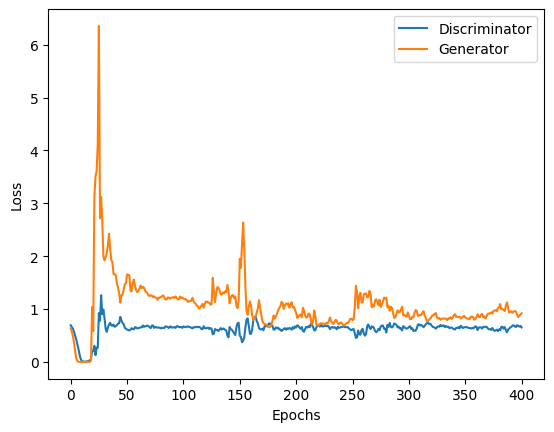

In [17]:
##
## Visualizing training losses
##
import matplotlib.pyplot as plt

plt.plot(d_losses, label='Discriminator')
plt.plot(g_losses, label='Generator')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

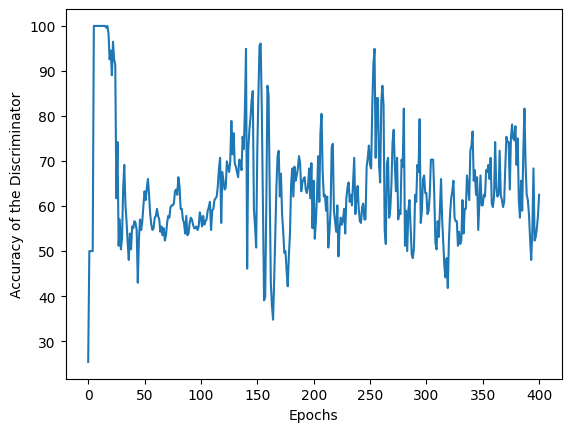

In [18]:
##
## Visualizing discriminator accuracy evolution
##
plt.plot(d_accuracies)
plt.xlabel('Epochs')
plt.ylabel('Accuracy of the Discriminator')
plt.show()

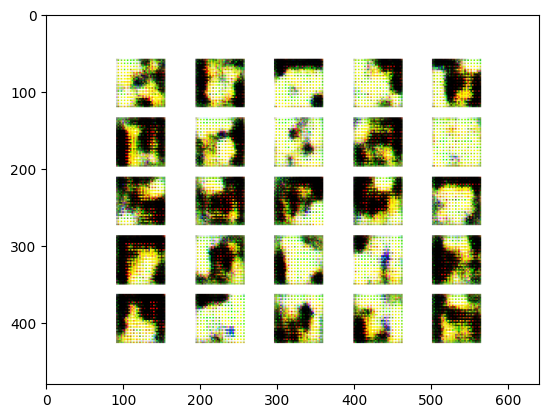

In [19]:
image = mpimg.imread("50.png")
plt.imshow(image)
plt.show()

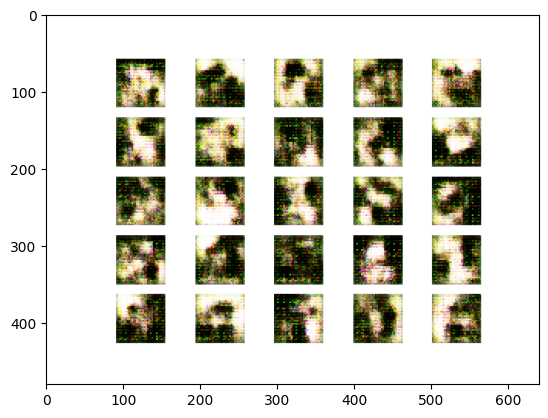

In [20]:
image = mpimg.imread("100.png")
plt.imshow(image)
plt.show()

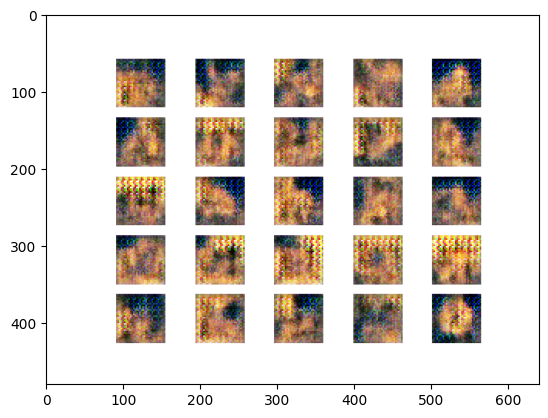

In [21]:
image = mpimg.imread("150.png")
plt.imshow(image)
plt.show()

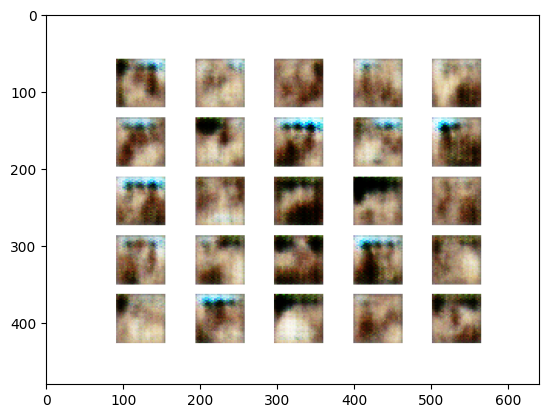

In [22]:
image = mpimg.imread("200.png")
plt.imshow(image)
plt.show()

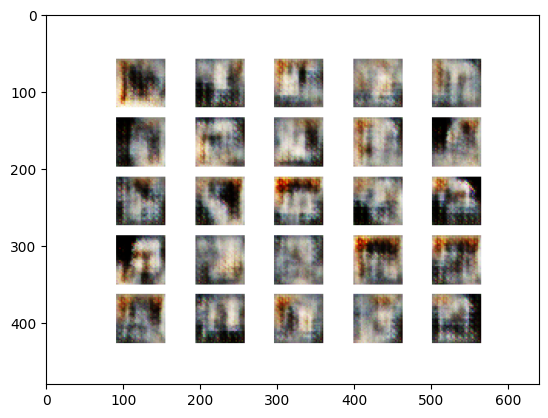

In [23]:
image = mpimg.imread("250.png")
plt.imshow(image)
plt.show()

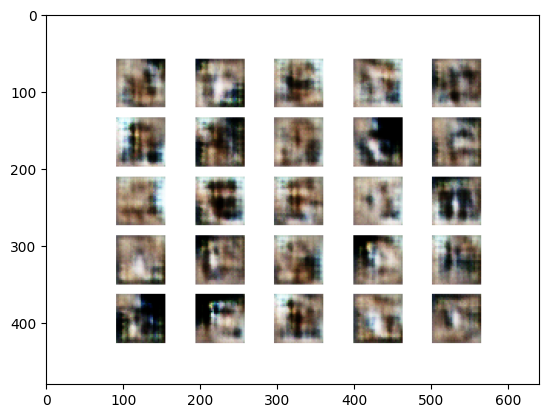

In [24]:
image = mpimg.imread("300.png")
plt.imshow(image)
plt.show()

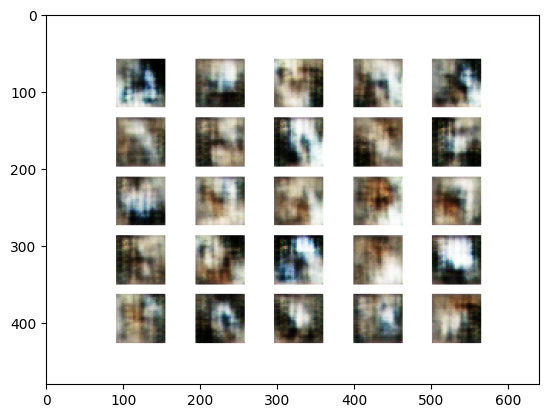

In [25]:
image = mpimg.imread("350.png")
plt.imshow(image)
plt.show()

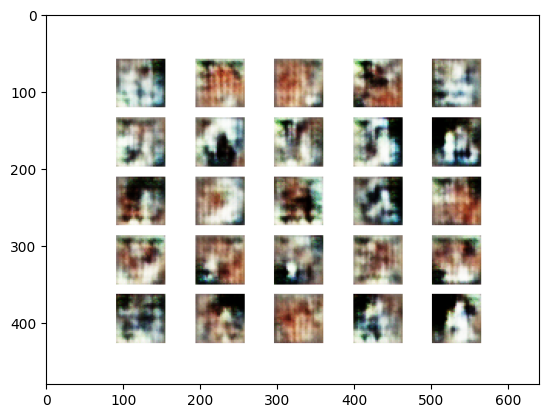

In [26]:
image = mpimg.imread("400.png")
plt.imshow(image)
plt.show()